# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.output_layer(x, activation=1)
    return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):

    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)

    correct_predictions = tf.equal(y_pred_classes, y_true)

    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.output_layer.w, neural_net.output_layer.b]
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [12]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc.numpy():.4f}")

Step: 100, Loss: 370.4348, Accuracy: 0.6406
Step: 200, Loss: 275.5772, Accuracy: 0.7578
Step: 300, Loss: 191.6140, Accuracy: 0.7812
Step: 400, Loss: 161.8927, Accuracy: 0.8203
Step: 500, Loss: 169.2711, Accuracy: 0.8242
Step: 600, Loss: 147.1376, Accuracy: 0.8242
Step: 700, Loss: 139.4362, Accuracy: 0.8242
Step: 800, Loss: 134.2767, Accuracy: 0.8594
Step: 900, Loss: 116.9745, Accuracy: 0.8750
Step: 1000, Loss: 111.9291, Accuracy: 0.8711
Step: 1100, Loss: 135.1958, Accuracy: 0.8594
Step: 1200, Loss: 103.3951, Accuracy: 0.9219
Step: 1300, Loss: 110.0052, Accuracy: 0.8867
Step: 1400, Loss: 96.7845, Accuracy: 0.9141
Step: 1500, Loss: 87.2765, Accuracy: 0.9102
Step: 1600, Loss: 99.5547, Accuracy: 0.8711
Step: 1700, Loss: 130.3500, Accuracy: 0.8516
Step: 1800, Loss: 106.4358, Accuracy: 0.8750
Step: 1900, Loss: 101.1872, Accuracy: 0.9180
Step: 2000, Loss: 95.5032, Accuracy: 0.8984
Step: 2100, Loss: 111.5175, Accuracy: 0.8867
Step: 2200, Loss: 66.3846, Accuracy: 0.9102
Step: 2300, Loss: 100.29

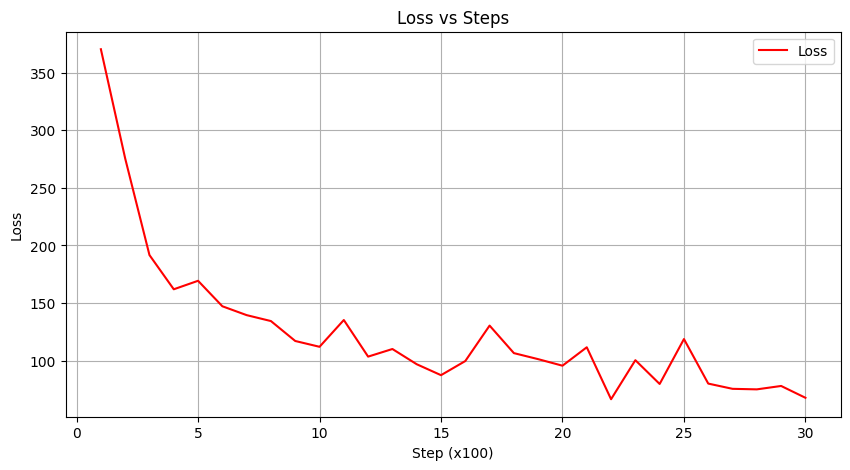

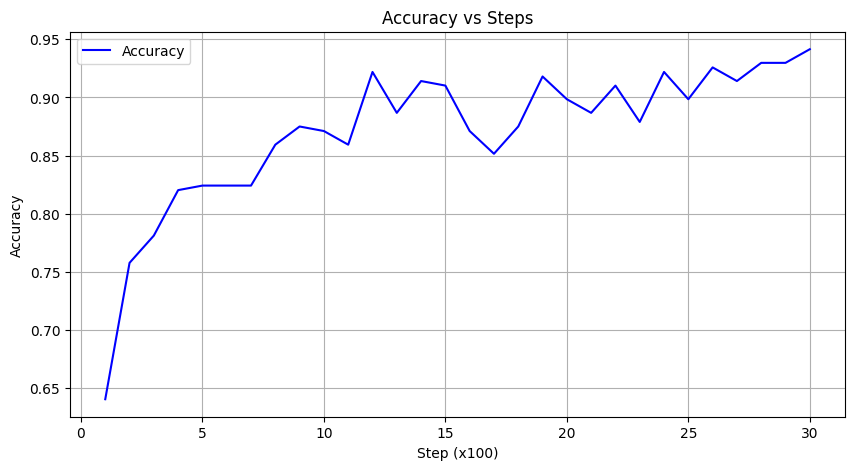

In [13]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss", color="red")
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.title("Loss vs Steps")
plt.legend()
plt.grid()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label="Accuracy", color="blue")
plt.xlabel("Step (x100)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Steps")
plt.legend()
plt.grid()
plt.show()


In [27]:
# Обчисліть точність навченої нейромережі
train_pred = neural_net(x_train)
train_pred = tf.argmax(train_pred, axis=1).numpy()

print("Training Classification Report:")
print(classification_report(y_train, train_pred, target_names=[str(i) for i in range(num_classes)]))

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_pred = tf.argmax(test_pred, axis=1).numpy()

print("Test Classification Report:")
print(classification_report(y_test, test_pred, target_names=[str(i) for i in range(num_classes)]))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5923
           1       0.98      0.97      0.97      6742
           2       0.90      0.92      0.91      5958
           3       0.91      0.89      0.90      6131
           4       0.92      0.92      0.92      5842
           5       0.91      0.87      0.89      5421
           6       0.95      0.94      0.95      5918
           7       0.93      0.94      0.93      6265
           8       0.83      0.92      0.87      5851
           9       0.90      0.88      0.89      5949

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000

Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       980
           1       0.98      0.97      0.97      1135
           2      

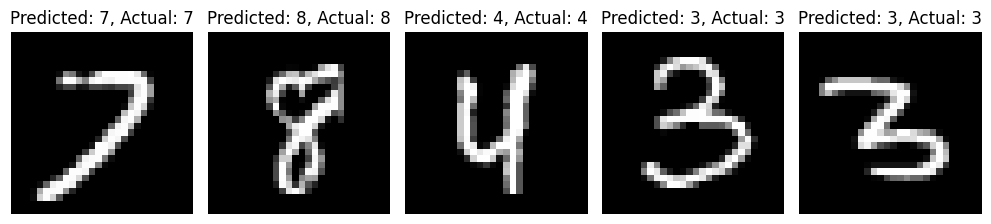

Correct predictions: 5
Incorrect predictions: 0
Accuracy on these 5 samples: 100%


In [29]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

random_indices = np.random.choice(len(x_test), size=5, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]
test_predictions = neural_net(test_images)
test_predictions = tf.argmax(test_predictions, axis=1)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {test_predictions[i]}, Actual: {test_labels[i]}")
    plt.axis('off')
    plt.tight_layout()
plt.show()

correct_predictions = np.sum(test_predictions == test_labels)
incorrect_predictions = len(test_labels) - correct_predictions

print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Accuracy on these 5 samples: {correct_predictions / len(test_labels) * 100:.0f}%")